# Distracted Driver Prediction

In [1]:
# Importing the Libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from glob import glob
import cv2
from IPython.display import display
import h5py
from PIL import Image

data_dir = r"...\imgs"

#### We need to limit memory growth so that we can initialize Conv Layers later. Otherwise tensorflow GPU will take over all of the GPU RAM

In [2]:
# Limiting memory growth
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

#### Let us define some Image Generators which will be used to flow the image data from the directories

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3,)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

train_generator = train_datagen.flow_from_directory(
        r"...\train",
        target_size=(160, 120),
        batch_size=64,
        class_mode='categorical', subset="training", color_mode='grayscale')

val_generator = val_datagen.flow_from_directory(
        r"...\train",
        target_size=(160, 120),
        batch_size=64,
        class_mode='categorical', subset="validation",  color_mode='grayscale')

Found 15702 images belonging to 10 classes.
Found 6722 images belonging to 10 classes.


#### Following are the classes that we have to classify images into

In [4]:
labels = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

col = {'c0': 'safe driving',
'c1': 'texting - right',
'c2': 'talking on the phone - right',
'c3': 'texting - left',
'c4': 'talking on the phone - left',
'c5':'operating the radio',
'c6': 'drinking',
'c7': 'reaching behind',
'c8': 'hair and makeup',
'c9': 'talking to passenger'}

#### Let us look at a few of the images belonging to different classes

In [5]:
def read_image(path):
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

				# c0 : safe driving


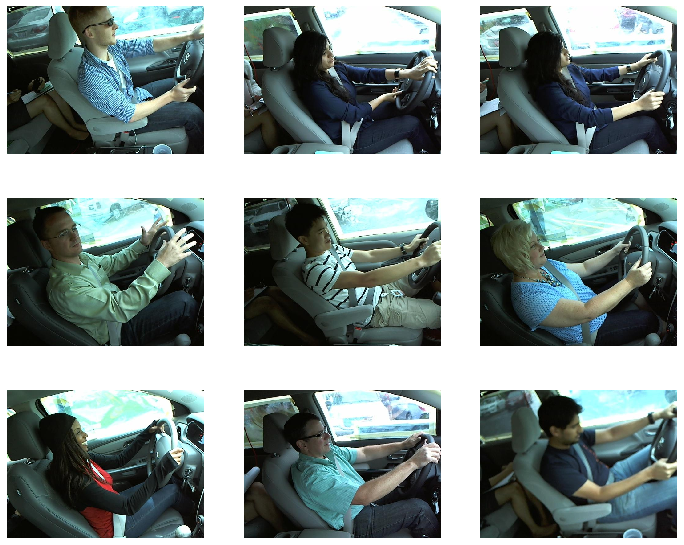

				# c1 : texting - right


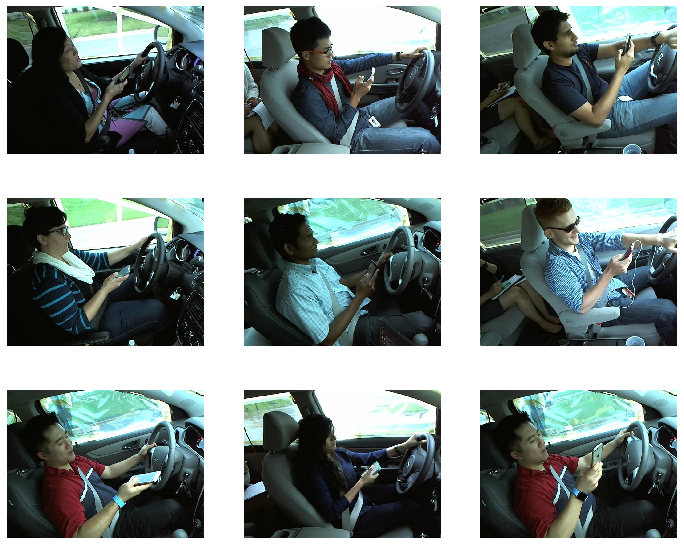

				# c2 : talking on the phone - right


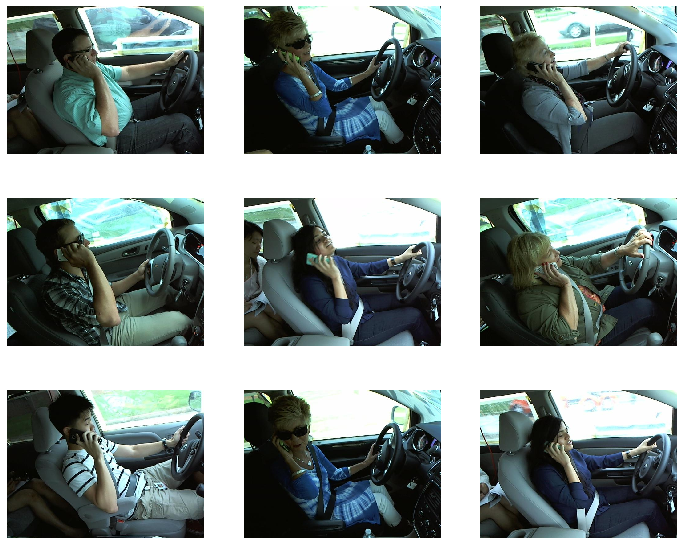

				# c3 : texting - left


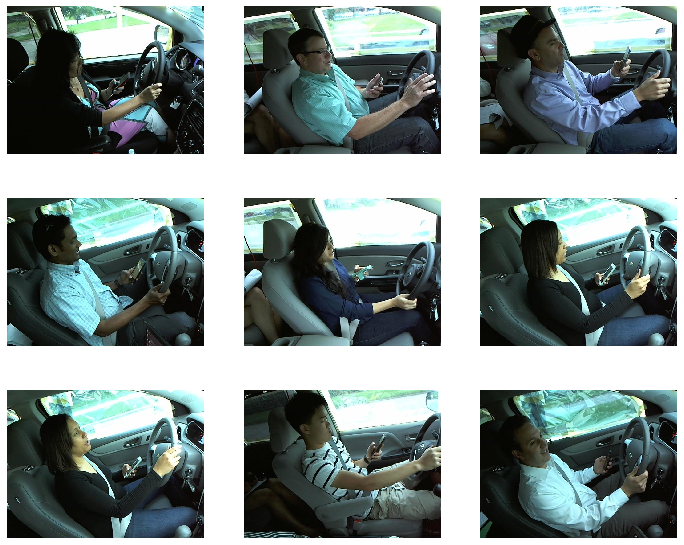

				# c4 : talking on the phone - left


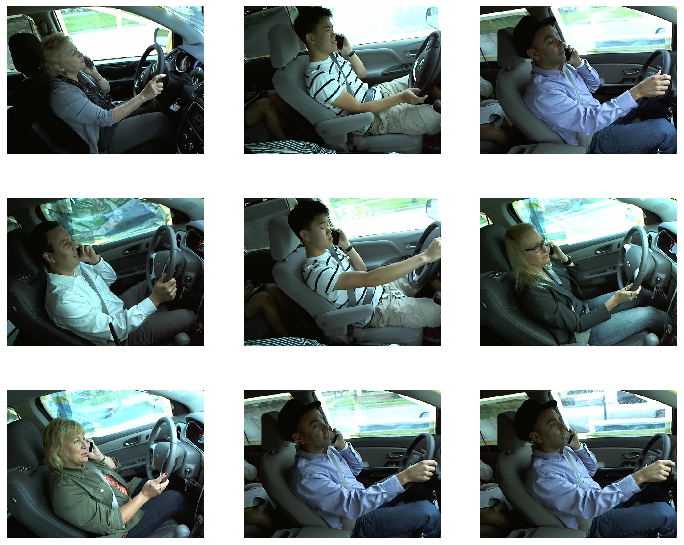

				# c5 : operating the radio


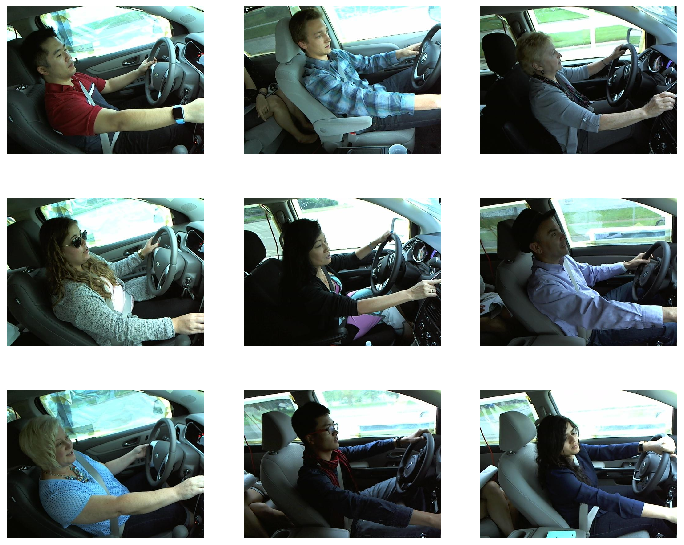

				# c6 : drinking


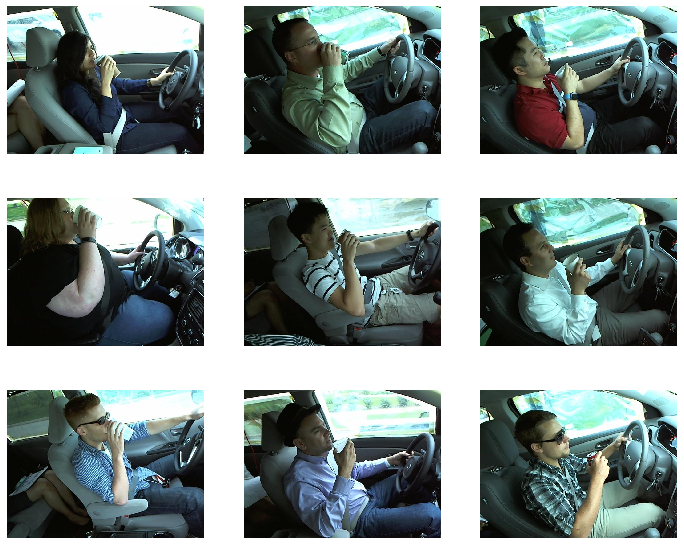

				# c7 : reaching behind


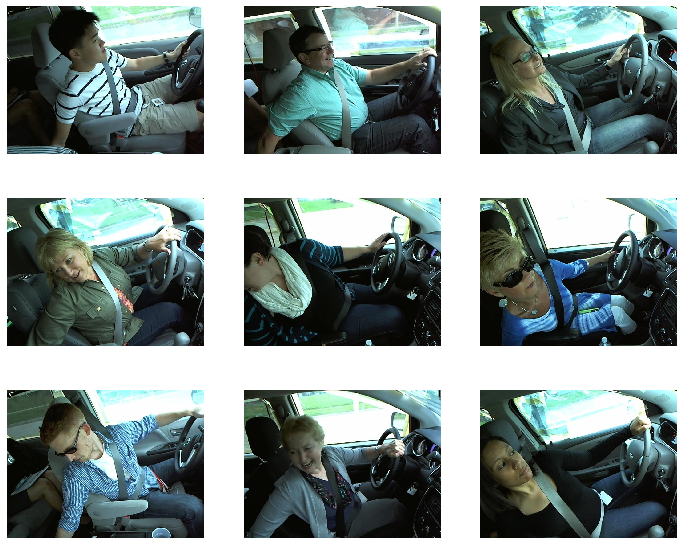

				# c8 : hair and makeup


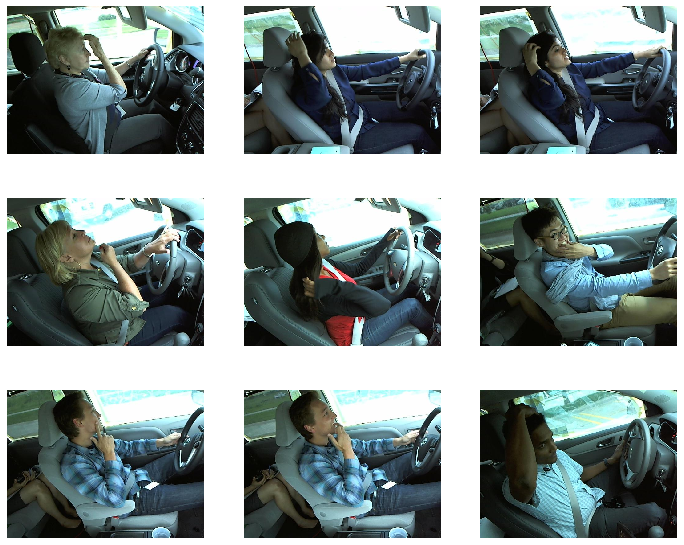

				# c9 : talking to passenger


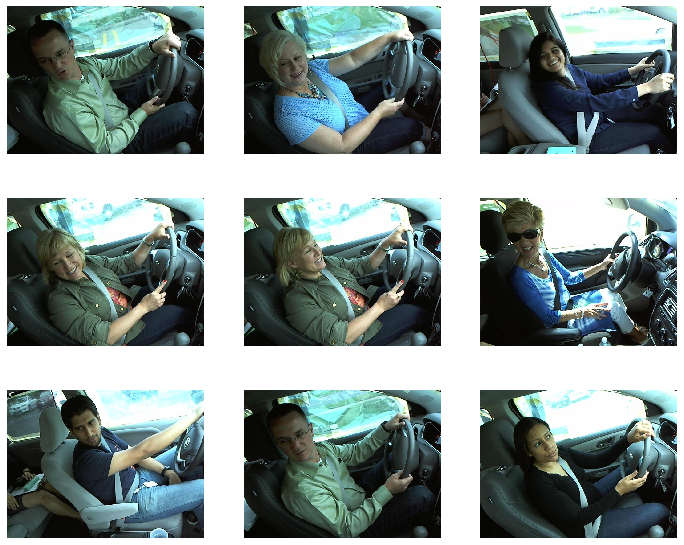

In [6]:
for label in labels:
    f, ax = plt.subplots(figsize=(12, 10))
    files = glob('{}/train/{}/*.jpg'.format(data_dir, label))
    
    print('\t\t\t\t# {} : {}'.format(label, col[label]))
    for x in range(9):
        plt.subplot(3, 3, x+1)
        image = read_image(files[x])
        plt.imshow(image)
        plt.axis('off')
    plt.show()

#### Now we design the Network

In [8]:
model = Sequential()

model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', input_shape = (160, 120, 1)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.33))
model.add(Dense(32, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(10, activation = 'softmax')) 

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 158, 118, 64)      640       
_________________________________________________________________
batch_normalization (BatchNo (None, 158, 118, 64)      256       
_________________________________________________________________
dropout (Dropout)            (None, 158, 118, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 156, 116, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 156, 116, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 78, 58, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 76, 56, 128)       7

In [13]:
model.compile(loss= 'categorical_crossentropy' , optimizer= 'adam' , metrics=[ 'accuracy' ])

#### Since this is a computationally expensive operation and my laptop cant run for longer durations at a stretch. I decided to save the weights whenever validation accuracy improved so that I can train in different sessions.

In [14]:
checkpoint = ModelCheckpoint("weights1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [15]:
model.load_weights("weights.h5")

#### Now we train the model. This accuracy was achieved with 2 training sessions each with 10 epochs

In [16]:
n_train = 15702
batch_size = 300
n_valid = 6722
history = model.fit_generator(
       train_generator,
       steps_per_epoch=n_train//batch_size,
       epochs=10,
       validation_data=val_generator,
       validation_steps=n_valid//batch_size,  callbacks=callbacks_list)

Epoch 1/10
52/52 [==============================] - ETA: 0s - loss: 0.1508 - accuracy: 0.9576
Epoch 00001: val_accuracy improved from -inf to 0.83736, saving model to weights1.h5
52/52 [==============================] - 181s 3s/step - loss: 0.1508 - accuracy: 0.9576 - val_loss: 0.5155 - val_accuracy: 0.8374
Epoch 2/10
52/52 [==============================] - ETA: 0s - loss: 0.1035 - accuracy: 0.9718
Epoch 00002: val_accuracy improved from 0.83736 to 0.96236, saving model to weights1.h5
52/52 [==============================] - 219s 4s/step - loss: 0.1035 - accuracy: 0.9718 - val_loss: 0.1504 - val_accuracy: 0.9624
Epoch 3/10
52/52 [==============================] - ETA: 0s - loss: 0.0669 - accuracy: 0.9841
Epoch 00003: val_accuracy improved from 0.96236 to 0.97372, saving model to weights1.h5
52/52 [==============================] - 240s 5s/step - loss: 0.0669 - accuracy: 0.9841 - val_loss: 0.0722 - val_accuracy: 0.9737
Epoch 4/10
52/52 [==============================] - ETA: 0s - loss:

#### Plotting some learning curves

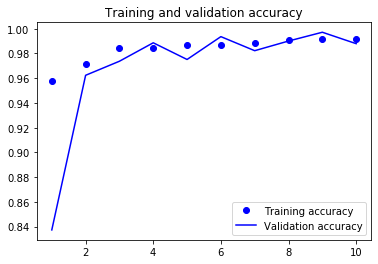

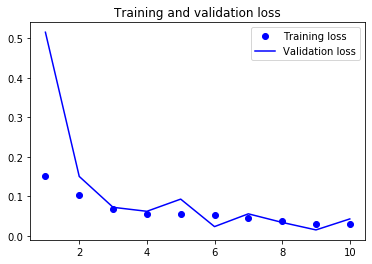

In [17]:
# Plot
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [25]:
model.save("distracted_driver_model")